In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer,StandardScaler,VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline 
from pyspark.sql.functions import col

In [2]:
spark = SparkSession.builder.appName('kmeans').getOrCreate()
spark

In [3]:
df = spark.read.csv('Datasets/kddcup.data_10_percent_corrected',inferSchema=True,header=False)
# df.show(5)
# df.printSchema()
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent",
                "hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root",
                "num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
                "count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
                "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
                "dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
                "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
df = df.toDF(*col_names)
df.show(5)
df.printSchema()

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_hos

Finding nulls

In [4]:
null_cond = col(col_names[0]).isNull()
for col_name in col_names[1:]:
    null_cond = null_cond | col(col_name).isNull()
df_filtered = df.filter(null_cond)
df_filtered.show() 

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_host_

In [5]:
df.groupby('label').count().show()

+----------------+------+
|           label| count|
+----------------+------+
|          smurf.|280790|
|            pod.|   264|
|   guess_passwd.|    53|
|        ipsweep.|  1247|
|      portsweep.|  1040|
|     loadmodule.|     9|
|buffer_overflow.|    30|
|       teardrop.|   979|
|           perl.|     3|
|        neptune.|107201|
|         normal.| 97278|
|           imap.|    12|
|           nmap.|   231|
|          satan.|  1589|
|           land.|    21|
|      ftp_write.|     8|
|            phf.|     4|
|       multihop.|     7|
|           back.|  2203|
|    warezmaster.|    20|
+----------------+------+
only showing top 20 rows



In [6]:
cat_features = df.select('protocol_type','service','flag')
num_features = df.drop('protocol_type','service','flag','label')
cat_features.show(5)
num_features.show(5) 

+-------------+-------+----+
|protocol_type|service|flag|
+-------------+-------+----+
|          tcp|   http|  SF|
|          tcp|   http|  SF|
|          tcp|   http|  SF|
|          tcp|   http|  SF|
|          tcp|   http|  SF|
+-------------+-------+----+
only showing top 5 rows

+--------+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+
|duration|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_r

In [7]:
assembler = VectorAssembler(inputCols=num_features.columns,outputCol='features')
data = assembler.transform(df)
data.show()

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+--------------------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_d

In [8]:
scaler = StandardScaler(inputCol="features",  
                        outputCol="scaledFeatures",  
                        withStd=True,  
                        withMean=True) 
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)
data.select('features','scaledFeatures').show() 

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,6,8,19,2...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.0677916519216...|
|(38,[1,2,8,19,20,...|[-0.067791

In [15]:
evaluator = ClusteringEvaluator(predictionCol='prediction',featuresCol='scaledFeatures',metricName='silhouette',distanceMeasure='squaredEuclidean')
silhouette_scores = []
for k in range(2,11):
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(data)
    predictions = model.transform(data)
    score = evaluator.evaluate(predictions)
    silhouette_scores.append(score)
    print(f"Silhouette score for k={k} : {score}")


Silhouette score for k=2 : 0.527827314157215
Silhouette score for k=3 : 0.4999898696021515
Silhouette score for k=4 : 0.6207556359758425
Silhouette score for k=5 : 0.6283819600383427
Silhouette score for k=6 : 0.574873108936549
Silhouette score for k=7 : 0.6754764930403446
Silhouette score for k=8 : 0.668914411958161
Silhouette score for k=9 : 0.7156680822547944
Silhouette score for k=10 : 0.7143636775694259


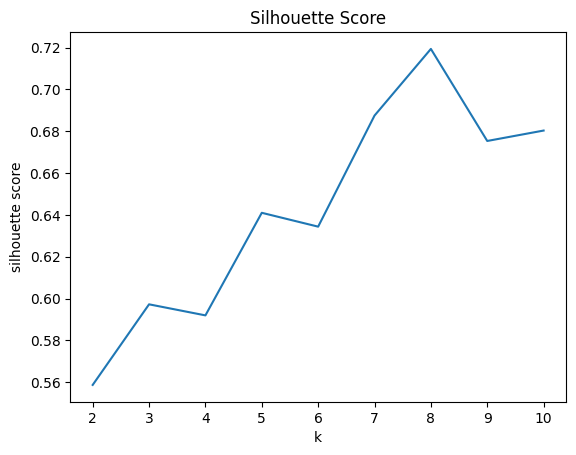

In [14]:
import matplotlib.pyplot as plt 
  
plt.plot(range(2,11),silhouette_scores) 
plt.xlabel('k') 
plt.ylabel('silhouette score') 
plt.title('Silhouette Score') 
plt.show()

In [19]:
kmeans = KMeans(featuresCol='scaledFeatures',k=6)
model = kmeans.fit(data)
preds = model.transform(data)
#preds.show()
preds.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|281393|
|         3|107494|
|         5|  9198|
|         4|   686|
|         0| 95248|
|         2|     2|
+----------+------+

